In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import toolz

import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

from keypoint_detection.dataset import image_tensor_to_ndarray, image_ndarray_to_tensor
from keypoint_detection.visualization import plot_image

## Define the Convolutional Neural Network
- 96x96 input images
- four convolutional layers with max pooling
- three fully connected layers

In [2]:
from keypoint_detection.network import KeypointDetector96
net = KeypointDetector96()
print(net)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Flatten()
  (5): Linear(in_features=9216, out_features=4096, bias=True)
  (6): ReLU()
  (7): Linear(in_features=4096, out_features=1024, bias=True)
  (8): ReLU

## Dataset and Transformations
- I chose to perform normalization and conversion to torch tensor inside the dataset class
- I wrote my own rescale and grayscale operations to operate on tensors instead of PIL images 

In [3]:
from keypoint_detection.dataset import KeypointsDataset, load_manifest, concat_samples
from keypoint_detection.transformation import Rescale, ToGrayscale 

dataset_path = '/home/nathan/cvnd/submodules/p1-facial-keypoints/data'
data_transform = toolz.compose(
    Rescale(target_height=96, target_width=96),
    ToGrayscale
)
training_manifest = load_manifest(f'{dataset_path}/training_frames_keypoints.csv')
train_dataset = KeypointsDataset(
    training_manifest, 
    f'{dataset_path}/training', 
    transform = data_transform 
)

In [4]:
print('Number of images: ', len(train_dataset))

for i in range(4):
    sample = train_dataset[i]
    print(i, sample.image.size(), sample.keypoints.size())

Number of images:  3462
0 torch.Size([1, 1, 96, 96]) torch.Size([136])
1 torch.Size([1, 1, 96, 96]) torch.Size([136])
2 torch.Size([1, 1, 96, 96]) torch.Size([136])
3 torch.Size([1, 1, 96, 96]) torch.Size([136])


In [5]:
batch_size = 12
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=0,
    collate_fn=concat_samples
)


## Before training, apply the model on a test sample

In [6]:
test_manifest = load_manifest(f'{dataset_path}/test_frames_keypoints.csv')
test_dataset = KeypointsDataset(
    test_manifest, 
    f'{dataset_path}/test', 
    transform = data_transform 
)

In [7]:
# load test data in batches
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=8,
    shuffle=True, 
    num_workers=0,
    collate_fn=concat_samples
)

## Visualize the predicted keypoints

In [8]:
from keypoint_detection import visualization as vis
images, keypoints = next(iter(test_loader))

In [9]:
predicted_keypoints = net(images).detach()

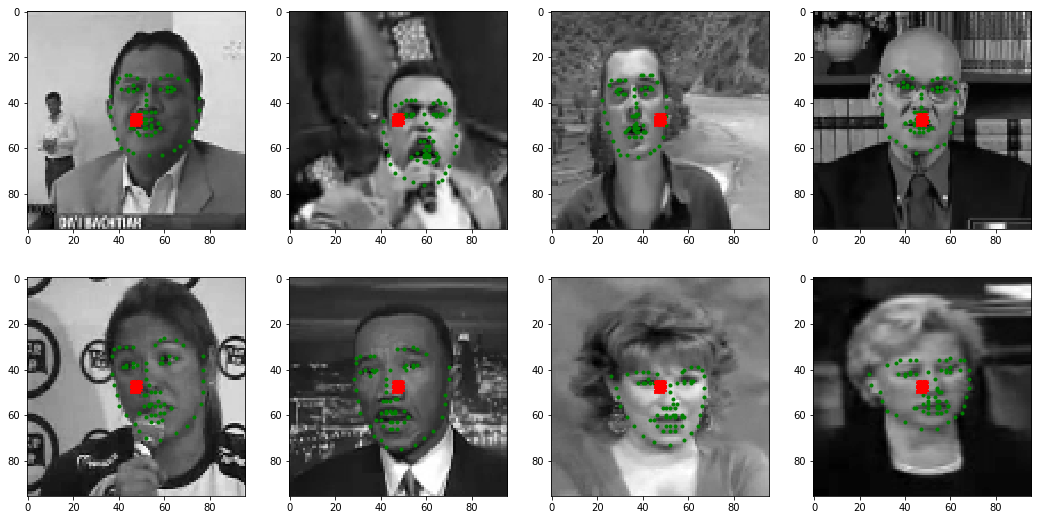

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 9))
for i in range(0, 8):
    row = i // 4 
    col = i % 4
    plot_image(images[[i]], keypoints[[i]], predicted_keypoints[[i]], fig=fig, ax=axes[row][col])

In [11]:
import torch.optim as optim
criterion = torch.nn.MSELoss()
optimizer = toolz.partial(torch.optim.Adam, lr=0.0001)

In [16]:
from keypoint_detection.train import train

In [165]:
train(net, train_loader, criterion, Optimizer=optimizer, epochs=10)

Epoch: 0, Batch: 0, Loss: 0.05040265992283821
Epoch: 0, Batch: 100, Loss: 0.009377733804285526
Epoch: 0, Batch: 200, Loss: 0.01137385331094265
Epoch: 1, Batch: 0, Loss: 0.010341276414692402
Epoch: 1, Batch: 100, Loss: 0.02663487382233143
Epoch: 1, Batch: 200, Loss: 0.011566782370209694
Epoch: 2, Batch: 0, Loss: 0.01469117496162653
Epoch: 2, Batch: 100, Loss: 0.016350019723176956
Epoch: 2, Batch: 200, Loss: 0.010645766742527485
Epoch: 3, Batch: 0, Loss: 0.007455901242792606
Epoch: 3, Batch: 100, Loss: 0.00816866010427475
Epoch: 3, Batch: 200, Loss: 0.0077310181222856045
Epoch: 4, Batch: 0, Loss: 0.0033902309369295835
Epoch: 4, Batch: 100, Loss: 0.00615693349391222
Epoch: 4, Batch: 200, Loss: 0.006788888014853001
Epoch: 5, Batch: 0, Loss: 0.0037620195653289557
Epoch: 5, Batch: 100, Loss: 0.002832808531820774
Epoch: 5, Batch: 200, Loss: 0.004585252143442631
Epoch: 6, Batch: 0, Loss: 0.002117313677445054
Epoch: 6, Batch: 100, Loss: 0.002209896920248866
Epoch: 6, Batch: 200, Loss: 0.0017389

In [12]:
with open('saved_models/keypoints_model_1.pt', 'rb') as f:
    state_dict = torch.load(f) 
net.load_state_dict(state_dict)

## Test data


In [13]:
predicted_keypoints = net(images).detach()

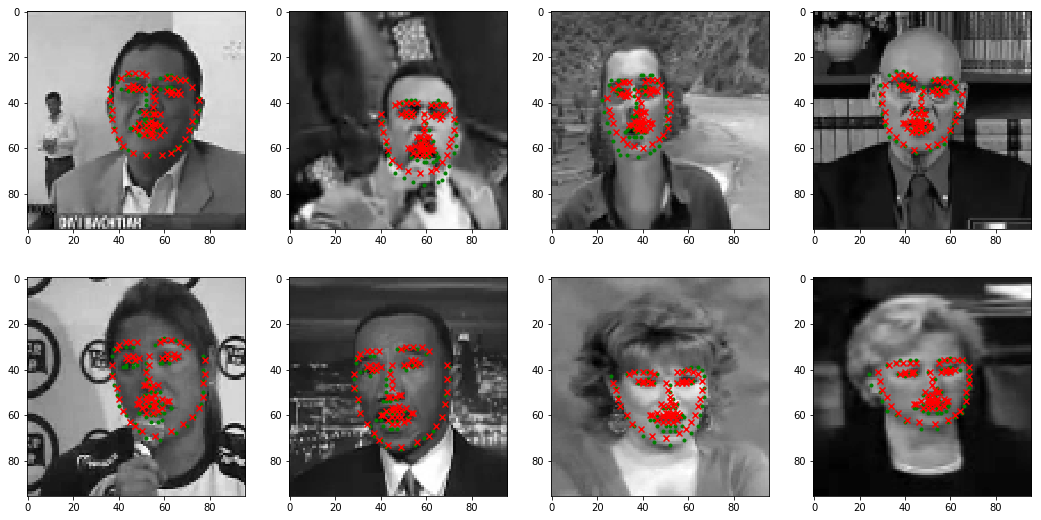

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 9))
for i in range(0, 8):
    row = i // 4 
    col = i % 4
    plot_image(images[[i]], keypoints[[i]], predicted_keypoints[[i]], fig=fig, ax=axes[row][col])

Once you've found a good model (or two), save your model so you can load it and use it later!

In [188]:
!mkdir -p saved_models
#model_dir = 'saved_models/'
#model_name = 'keypoints_model_1.pt'
#torch.save(net.state_dict(), model_dir+model_name)

### Question 1: What optimization and loss functions did you choose and why?


#### Why the Adam optimizer?
1. I wanted to try larger batch sizes without worrying about local minima and believed momentum could help.
2. Adam was successful for training NamishNet: https://arxiv.org/pdf/1710.00977.pdf

### Why MSE Loss?
1. It is easy to interperate (mean euclidean distance between points) 
2. Is symmetric (i can't decide that certin key points are more important others)
3. Prioritizes improving keypoints that are far off since $\frac{d}{dx}x^2 = x$ grows with x

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

I started with a pretty standard model, 4 convolutions followed by 2 fully connected layers.
It doesn't seem to overfit, so I found no need for dropout layers.

I also tried a shallower modele to see if my first model was overkill.  I got worse results and stuck with my first model.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

I picked 12 and stuck with it.  I should experiment, but I didn't.  In theory...
- Too small a batch size -> slow training, too much noise in the gradient
- Too large a batch size -> out of memory on gpu, not enough noise in the gradient.

12 seemed to work just fine

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [20]:
net[0][0]

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

[[ 0.10917839 -0.01935061  0.06738155]
 [-0.3013672   0.23616166  0.36455756]
 [-0.29858208 -0.29776275  0.08334838]]
(3, 3)


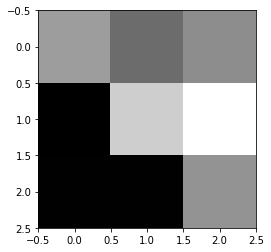

In [153]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net[0][0].weight.data

w = weights1.numpy()

filter_index = 10

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [154]:
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
output = cv2.filter2D(image_tensor_to_ndarray(images), 0, w[filter_index][0])

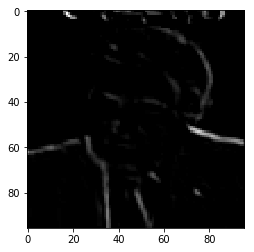

In [155]:
plt.imshow(output, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


It looks like this picks up edges, especially those that are perpendicular to the south-west direction.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!